In [4]:
import pandas as pd
import numpy  as np
import os
import re
import datetime
import pytz
import copy
from collections import Counter
from emoji   import UNICODE_EMOJI
from functools   import reduce
import sys
sys.path.append('/home/handeully/')
import bigquery_etl as bq
import operator
import time
from IPython.display import display
# NLP Env.
import nltk
from nltk import FreqDist
from nltk.corpus   import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk.corpus   import wordnet
from nltk.corpus   import sentiwordnet as swn
from nltk import sent_tokenize,word_tokenize,pos_tag

# stop_words = stopwords.words('english')
import spacy
import gensim
from gensim import corpora
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import ray
import psutil
from tqdm.notebook import tqdm

#glove
from glove import Corpus,Glove

# Vis Env.
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# GCP Env.
import google.auth
from google.cloud import bigquery
from googletrans import Translator
from google_trans_new import google_translator

# Coding Env.
import warnings
from pandas.core.common import SettingWithCopyWarning

import evalml
from evalml import AutoMLSearch

credentials, project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

client = bigquery.Client(credentials=credentials, project=project_id )
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


#initialization ray
num_logit_cpus = psutil.cpu_count()
print(f'multiprocessing using {num_logit_cpus} cores')
ray.init(ignore_reinit_error=True,num_cpus=num_logit_cpus)


multiprocessing using 16 cores


2021-06-29 06:07:25,082	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8267


{'node_ip_address': '10.178.0.34',
 'raylet_ip_address': '10.178.0.34',
 'redis_address': '10.178.0.34:18657',
 'object_store_address': '/tmp/ray/session_2021-06-29_06-07-24_509526_4163367/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-29_06-07-24_509526_4163367/sockets/raylet',
 'webui_url': '127.0.0.1:8267',
 'session_dir': '/tmp/ray/session_2021-06-29_06-07-24_509526_4163367',
 'metrics_export_port': 58909,
 'node_id': '256d0a1b2e35af26370750cf5773b325fed04867fa7f0f4bb93ef3ed'}

In [6]:
review_sql = '''
           WITH base_table AS (SELECT A.*,B.prdct_ctgry_4_5,B.brand,RANK() OVER(partition by A.reviewId order by crawlTime desc) as rank
                                FROM `market-analysis-project-91130`.crwl.amz_rvw_all A 
                                LEFT JOIN `market-analysis-project-91130`.meta.crwl_amz_pdt_mst_all B ON A.asin =B.asin)
            SELECT  A.reviewId,
                    A.region,		
                    A.brand as original_brand,
                    b.brand as map_ori_brand,
                    CASE WHEN lower(b.brand_adj) IS NOT NULL
                         THEN lower(b.brand_adj)
                         ELSE lower(A.brand)
                         END as brand,
                    b.brand_adj_rank  as  brand_rank,
                    C.category_rev,
					C.subcategory_1_rev,
					C.subcategory_2_rev,
					C.inch_from_title_rev,
					C.inch_from_titleDesc_rev,
                    A.asin,
                    date(A.date)as date,
                    A.helpful_vote,
                    A.initialTime,
                    A.rating,
                    A.reviewer_url,
                    A.product_option,
                    A.title,
                    A.verified_purchase,
                    A.crawlTime,
                    lower(A.review_text) as review_text,
                    A.prdct_ctgry_4_5 as category
            FROM base_table A 
            LEFT JOIN rvw_mst.bsr_top10_brand  b on lower(A.brand) = lower(b.brand)  and lower(A.prdct_ctgry_4_5) = lower(b.bsr_ctgry) and b.chnnl_nm ='US AMZ'
			LEFT JOIN rvw_mst.amz_ttl_asin_list_2105_asin_flag C ON A.asin=C.asin AND C.prdct_title IS NOT NULL
            WHERE A.prdct_ctgry_4_5 IN ('Beds','Bed Frames','Mattresses','Box Springs','Sofas & Couches','Mattress Toppers')
            and rank = 1
            AND A.reviewId not in (select reviewId
                                      from (
                                             SELECT reviewId,count(DISTINCT prdct_ctgry_4_5)--A.*,B.prdct_ctgry_4_5,RANK() OVER(partition by A.reviewId order by crawlTime desc) as rank
                                             FROM base_table
                                             GROUP BY reviewId 
                                             HAVING count(DISTINCT prdct_ctgry_4_5) > 1
                                         )
                                 )		
            AND substring(A.date,1,4) >= '2019'
            and A.brand is not null
            order by brand,A.prdct_ctgry_4_5,reviewId,date 
'''



filter_sql = f''' 
                    SELECT distinct stopword 
                    FROM market-analysis-project-91130.taxonomy.stp_wds;
                  '''

factor_sql = '''
                SELECT distinct T2.category,T1.*
                FROM (SELECT a.cmpl_fc1,a.cmpl_fc1_cd,b.cmpl_fc2,c.synonym,c.lemma
                      FROM market-analysis-project-91130.taxonomy.cpl_fc1 a 
                      FULL OUTER JOIN market-analysis-project-91130.taxonomy.cpl_fc2 b   on lower(a.cmpl_fc1_cd) = lower(b.cmpl_fc1_cd)
                      FULL OUTER JOIN market-analysis-project-91130.taxonomy.rvw_kyw_syn c on lower(b.cmpl_fc2) = lower(c.cmpl_fc2) 
                ) T1
                LEFT JOIN market-analysis-project-91130.taxonomy.pdt_ctg T2 ON   T1.cmpl_fc1_cd = T2.cmpl_fc1_cd 
            '''

bsr_brand_sql = '''
                SELECT DISTINCT *
                FROM (
                    SELECT
                        t1.category as prdct_ctgry_4_5 ,
                        LOWER(t1.brand) as brand ,
                        t1.rank ,
                        CASE
                            WHEN t2.brand_adj IS NOT NULL THEN lower(t2.brand_adj)
                            ELSE lower(t1.brand)
                        END AS brand_adj
                    FROM
                        (
                        SELECT
                            bsr_ctgry as Category,
                            lower(brand) as brand,
                            min(brand_adj_rank) as rank
                        FROM
                            rvw_mst.bsr_top10_brand
                        WHERE
                            bsr_ctgry IN ('Beds','Bed Frames','Mattresses','Box Springs','Sofas & Couches','Mattress Toppers')
                        GROUP BY
                            bsr_ctgry,
                            lower(brand) ) t1
                    LEFT JOIN `market-analysis-project-91130`.meta.brand_mapping t2 on
                        t1.brand = lower(t2.brand)
                )
                ORDER BY
                        1,
                        3

              '''

part_sql = '''
              SELECT *
              FROM market-analysis-project-91130.taxonomy.prt_wds
           '''


pi_cf_sql = '''
            SELECT *
            FROM taxonomy.pi_complaint_review
            '''

In [7]:
cpl_factor    = convert_lowercase(bq.select_query(factor_sql))
cmpl_fc_list  = list(set(cpl_factor['cmpl_fc1'].unique().tolist())|set(cpl_factor['cmpl_fc2'].unique().tolist())|set(cpl_factor['synonym'].unique().tolist())|set(cpl_factor['lemma'].unique().tolist()))
multi_express = list(filter(lambda x: len(x.split(' '))>1 , cmpl_fc_list))
# Put this list for MWE Tokenizing
mwe = [tuple(f.split(' ')) for f in multi_express]
print('complain factor    : ' ,cpl_factor.shape)
print(f'all complain factor list  : {len(cmpl_fc_list)}')
print(f'multi_express lenth : {len(mwe)}')

complain factor    :  (4753, 6)
all complain factor list  : 1104
multi_express lenth : 444


In [8]:
bsr_brand_df   = convert_lowercase(bq.select_query(bsr_brand_sql))
top_brand      = list(set(bsr_brand_df['brand'].unique()))
df             = convert_lowercase(bq.select_query(pi_cf_sql))
stopword_df    = convert_lowercase(bq.select_query(filter_sql))
parts_df       = convert_lowercase(bq.select_query(part_sql))
stop_words     = stopword_df['stopword'].tolist()
print('Original review_data        : ' ,df.shape)
print(f'''bsr brand count : {len(top_brand)} \nbsr_brand_list : {top_brand}''')
print('stop_words         : ' ,len(stop_words))
print('bsr_brand_sql      : ' ,bsr_brand_df.shape)
print('parts_df           : ' ,parts_df.shape)

Original review_data        :  (16785, 28)
bsr brand count : 149 
bsr_brand_list : ['prepac', 'signature sleep', 'box spring king', 'mattress america', 'karrism', '45minst', 'molblly', 'zayton', 'primasleep', 'serta', 'lucid', 'giantex', 'sleep on latex', 'mcc brands, llc', 'comfort bedding', 'edenbrook', 'simple life', 'casper sleep', 'comasach', 'spinal solution', 'poly & bark', 'yaheetech', 'thrive', 'sleep innovations', 'glory furniture', 'mainstay', 'max & lily', 'linenspa', 'nod by tuft & needle', 'dhp', 'best choice products', 'modway', 'continental mattress', 'bedecor', 'flash furniture', 'home life', 'ghostbed', 'avenco', 'jingwei', 'olee sleep', 'mellow', 'wanse', 'dynastymattress', 'spring coil', 'iyee nature', 'gold star mattress', 'morden fort', 'spa sensations', 'the purple mattress', 'sleeptune', 'viscosoft', 'linon home dcor', 'milliard', 'oyt', 'recci', 'swiss ortho sleep', 'ztozz', 'harper & bright designs', 'mellcom', 'brooklyn bedding', 'krisler', 'everlane home', '

In [9]:
# (Step1-1) data filtering  
def make_anal_df(df):
    df_1 = df
    df_1['rat_sentiment'] =  np.where(df_1['rating']<=2, 0,1) ## give rating sentiment 1~2 star = neg /  5 star = pos
    df_1['year']       = df_1.yearmonth.str[0:4]
    df_1['month']      = df_1.yearmonth.str[5:]
    df_1['date'] = pd.to_datetime(df_1.date)
    df_1['yearmonth'] = df_1['date'].dt.strftime('%Y%m')
    df_1['year']      = df_1['date'].dt.strftime('%Y')
    df_1['month']     = df_1['date'].dt.strftime('%m')
    df_1 = convert_uppercase(df_1)
#     df_1 = pd.merge(df_1,bsr_brand_df[['brand','brand_adj','prdct_ctgry_4_5','rank']],how='inner',left_on=['brand','category'],right_on=['brand','prdct_ctgry_4_5'])
    return df_1

neg_df = make_anal_df(df)
neg_df = neg_df.drop_duplicates('reviewId')
data = neg_df[['cmpl_fc1','review_text']]



# print(f'rating(1~2) negative review : {neg_df.shape}')

# Start AutoML

,cmpl_fc1
0,uncomfortable
1,durability
2,sound
3,durability
4,durability
...,...
16780,durability
16781,durability
16782,durability
16783,too hard


In [58]:
import woodwork as ww
print(ww.__version__)
from woodwork import list_semantic_tags,list_logical_types
# list_semantic_tags()
# list_logical_types()

0.4.1


In [123]:
from evalml.utils import infer_feature_types
# Load Data FROM Big Query(db connection)
def convert_lowercase(df):
    df_1 =  df.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
    upper_list = ['reviewId','asin','size','cmpl_fc1_cd']
    cols = list(set(upper_list)& set(df_1.columns))
    df_1[cols] = df_1[cols].apply(lambda x: x.astype(str).str.upper() if(x.dtype == 'object') else x)
    return df_1

def convert_uppercase(df):
    upper_list = ['reviewId','asin']
    cols = list(set(upper_list)& set(df.columns))
    df[cols] = df[cols].apply(lambda x: x.astype(str).str.upper() if(x.dtype == 'object') else x)
    return df

def top20_df_brand(df):
    br_cat_rvw_rank  = pd.pivot_table(df, index = ['brand'], values = ['reviewId'], columns = ['prdct_ctgry_4_5'], aggfunc = ['count'], fill_value = 0, margins = True)#.reset_index()#.to_csv('ddd.csv')
    br_rvw_rank_all  = br_cat_rvw_rank['count']['reviewId']['All'].reset_index()
    br_rvw_rank_all  = br_rvw_rank_all.loc[(br_rvw_rank_all['brand'] != 'All'),]
    br_rvw_rank_all['rank'] = br_rvw_rank_all['All'].rank(ascending=False).astype(int)
    br_rvw_rank_all  = br_rvw_rank_all.sort_values(by='rank',ascending=True)
    br_rvw_rank_all  = br_rvw_rank_all[0:20]
    return br_rvw_rank_all['brand'].tolist()

#check multiprocessing progress 
def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])
        
def to_feather_df(df,name):
    df.reset_index().to_feather(f'temp/{name}.ftr')
    print(f'temp/{name}.ftr에 저장완료')
    
def ray_multiprocessing_progress(ray_df):
    for x in tqdm(to_iterator(ray_df), total=len(ray_df)):
        pass
    ray_df  = pd.concat(ray.get(ray_df))
    return ray_df


data   = convert_lowercase(bq.select_query(shiny_sql))
# reviews column name
x_cols = 'review_text'
# class columns name 
y_cols = 'cmpl_fc1'

logical_types = {
#     'reviewId' : 'IPAddress',
    y_cols : 'Categorical',
    x_cols: 'NaturalLanguage'
}

data.ww.init(logical_types=logical_types)
data.ww.select(include=['Categorical'])

X = data.drop(columns=[y_cols])
y = data[y_cols]
X_train, X_holdout, y_train, y_holdout = evalml.preprocessing.split_data(X, y, problem_type='multiclass', test_size=0.2, random_seed=0)
automl = AutoMLSearch(X_train=X_train, y_train=y_train,
                      problem_type='multiclass',
                      objective = 'accuracy', 
                      additional_objectives = ['f1','recall', 'precision'],
                      max_batches=1,
                      optimize_thresholds=True)

automl.search()
best_pipeline = automl.best_pipeline
automl.describe_pipeline(automl.rankings.iloc[0]["id"])
scores = best_pipeline.score(X_holdout,y_holdout,objectives=evalml.objectives.get_core_objectives('multiclass'))

Generating pipelines to search over...
8 pipelines ready for search.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Multiclass. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: extra_trees, catboost, xgboost, random_forest, decision_tree, lightgbm, linear_model



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Multiclass Classification Pipeline
Mode Baseline Multiclass Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Log Loss Multiclass: 27.626

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Classifier w/ Text Featurization Component + SMOTE Oversampler + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Log Loss Multiclass: 2.511
Decision Tree Classifier w/ Text Featurization Component + SMOTE Oversampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Multiclass: 3.219
Random Forest Classifier w/ Text Featurization Component + SMOTE Oversampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Multiclass: 2.480
LightGBM Classifier w/ Text Featurization Component + SMOTE Oversampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Multiclass: 2.680
Logistic Regres

In [124]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,3,Random Forest Classifier w/ Text Featurization...,3,2.480378,0.016049,2.489815,91.021648,False,"{'SMOTE Oversampler': {'sampling_ratio': 0.25,..."
1,1,Elastic Net Classifier w/ Text Featurization C...,1,2.510851,0.017738,2.525544,90.911345,False,"{'SMOTE Oversampler': {'sampling_ratio': 0.25,..."
2,5,Logistic Regression Classifier w/ Text Featuri...,5,2.510887,0.017725,2.525578,90.911215,False,"{'SMOTE Oversampler': {'sampling_ratio': 0.25,..."
3,6,XGBoost Classifier w/ Text Featurization Compo...,6,2.515125,0.019796,2.517876,90.895874,False,"{'SMOTE Oversampler': {'sampling_ratio': 0.25,..."
4,7,Extra Trees Classifier w/ Text Featurization C...,7,2.568745,0.009902,2.575929,90.701781,False,"{'SMOTE Oversampler': {'sampling_ratio': 0.25,..."
5,4,LightGBM Classifier w/ Text Featurization Comp...,4,2.679813,0.033236,2.693787,90.299745,False,"{'SMOTE Oversampler': {'sampling_ratio': 0.25,..."
6,8,CatBoost Classifier w/ Text Featurization Comp...,8,2.858841,0.002742,2.859425,89.651708,False,"{'SMOTE Oversampler': {'sampling_ratio': 0.25,..."
7,2,Decision Tree Classifier w/ Text Featurization...,2,3.218821,0.032125,3.191262,88.348670,False,"{'SMOTE Oversampler': {'sampling_ratio': 0.25,..."
8,0,Mode Baseline Multiclass Classification Pipeline,0,27.626208,0.001043,27.627412,0.000000,False,{'Baseline Classifier': {'strategy': 'mode'}}



********************************************************************************
* Random Forest Classifier w/ Text Featurization Component + SMOTE Oversampler *
********************************************************************************

Problem Type: multiclass
Model Family: Random Forest

Pipeline Steps
1. Text Featurization Component
2. SMOTE Oversampler
	 * sampling_ratio : 0.25
	 * k_neighbors_default : 5
	 * n_jobs : -1
	 * sampling_ratio_dict : None
	 * k_neighbors : 5
3. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1

Training
Training for multiclass problems.
Total training time (including CV): 103.6 seconds

Cross Validation
----------------
             Log Loss Multiclass  MCC Multiclass  AUC Weighted  AUC Macro  AUC Micro  Precision Weighted  Precision Macro  Precision Micro  F1 Weighted  F1 Macro  F1 Micro  Balanced Accuracy Multiclass  Accuracy Multiclass # Training # Validation
0                          2.490           0.151   

In [128]:
scores

OrderedDict([('MCC Multiclass', 0.152991501788972),
             ('Log Loss Multiclass', 2.4901827536589125),
             ('AUC Weighted', 0.720003120329683),
             ('AUC Macro', 0.7178094091520524),
             ('AUC Micro', 0.8091409109797512),
             ('Precision Weighted', 0.22738078300641326),
             ('Precision Macro', 0.1406098561960133),
             ('Precision Micro', 0.266805990943922),
             ('F1 Weighted', 0.18093942651608239),
             ('F1 Macro', 0.08257468100766002),
             ('F1 Micro', 0.266805990943922),
             ('Balanced Accuracy Multiclass', 0.10126120624511702),
             ('Accuracy Multiclass', 0.266805990943922)])

In [129]:
best_pipeline.save("model/cf_automl.pkl")

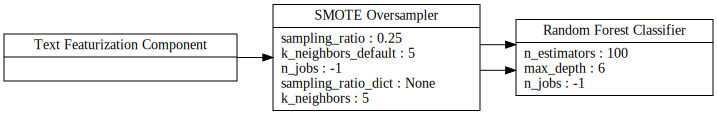

In [131]:
best_pipeline.graph()

                  precision    recall  f1-score   support

        recovery       0.27      0.29      0.28       323
      durability       0.24      0.78      0.37       575
       defective       0.00      0.00      0.00       264
        too soft       0.00      0.00      0.00        54
        too hard       0.40      0.66      0.50       258
           sound       0.00      0.00      0.00       140
   missing parts       0.64      0.11      0.19       129
            odor       0.00      0.00      0.00        31
   uncomfortable       0.67      0.04      0.07       166
      size issue       0.00      0.00      0.00       151
 shipping damage       0.33      0.05      0.08       167
        delivery       0.12      0.02      0.04        46
      fiberglass       0.00      0.00      0.00        37
     cover issue       0.00      0.00      0.00        33
customer service       0.05      0.09      0.07        11
          others       0.30      0.10      0.15       210
  customer er

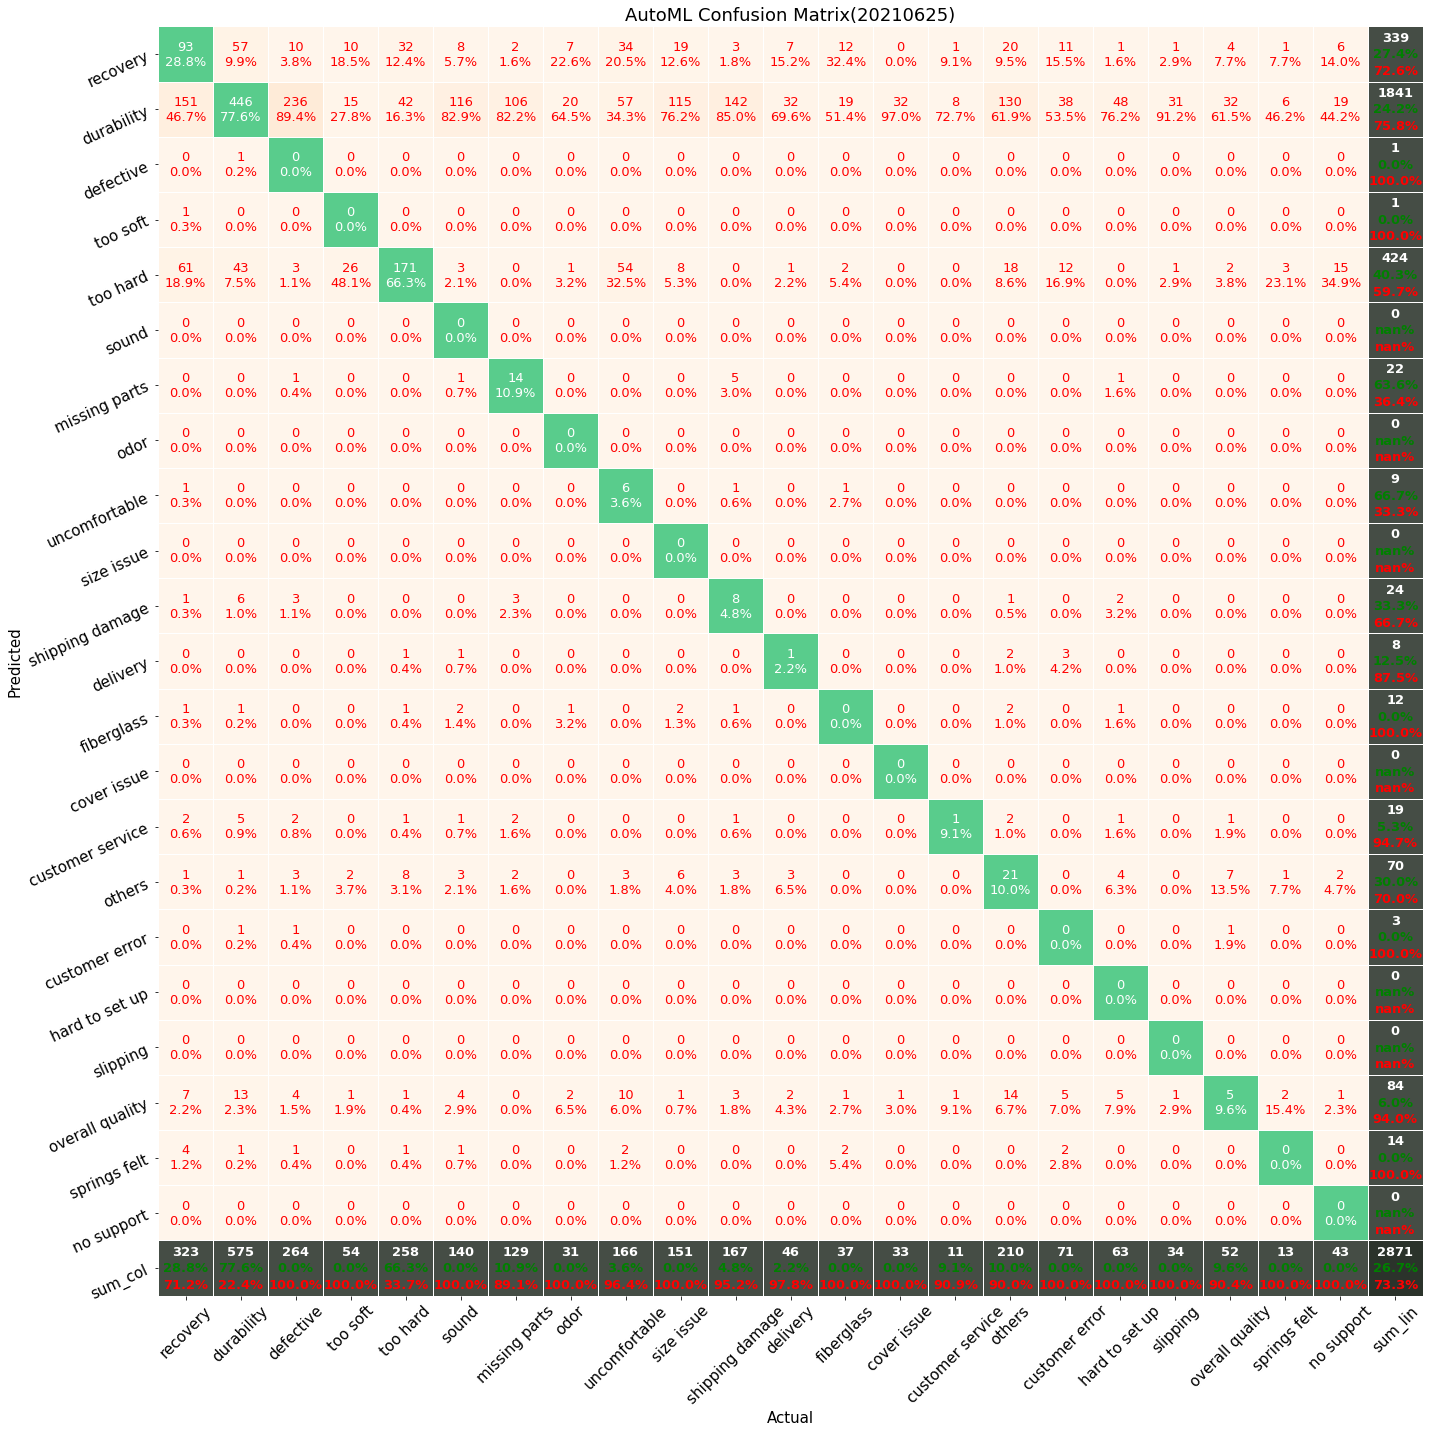

0.266805990943922

2021-06-27 12:05:19,330	WARNING worker.py:1107 -- The node with node id 18d56563293570b405450b7dbc9e4e4930015aa598098df1a46c7ea0 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.


In [140]:
best_model = automl.load('model/cf_automl.pkl')
# predicting testing data
y_prb = best_model.predict_proba(X_holdout)
y_prob = y_prb.idxmax(axis="columns")
y_holdout = y_holdout.reset_index(drop=True)

val_aa = pd.DataFrame({'y_true':y_holdout ,'y_prd':y_prob,'y_true_cd':y_holdout,'y_prd_cd':y_prob})

y_cf_dic = {'recovery'  : 1, 
            'durability': 2,
            'defective' : 3, 
            'too soft'  : 4, 
            'too hard'  : 5,
            'sound'     : 6,
            'missing parts' : 7,
            'odor' : 8,
            'uncomfortable' : 9,
            'size issue' : 10,
            'shipping damage' : 11,
            'delivery'   : 12,
            'fiberglass' : 13,
            'cover issue': 14, 
            'customer service' : 15, 
            'others' : 16, 
            'customer error' : 17,
            'hard to set up' : 18, 
            'slipping' : 19, 
            'overall quality' : 20,
            'springs felt' : 21,
            'no support' : 22,
           }


val_df = val_aa.replace({"y_true_cd": y_cf_dic,
                         "y_prd_cd": y_cf_dic})
val_df[['y_true_cd','y_prd_cd']] = val_df[['y_true_cd','y_prd_cd']].astype(int)

from sklearn.metrics import classification_report,plot_confusion_matrix,confusion_matrix,accuracy_score

y_true = val_df['y_true_cd'].tolist()
y_pred = val_df['y_prd_cd'].tolist()
target_name = list(y_cf_dic)
# target_name.remove('no support')
# print(target_name)
print(classification_report(y_true, y_pred,target_names=target_name))
cm=confusion_matrix(y_true,y_pred)
print(cm)
_test_data_class(y_true,y_pred)
accuracy_score(y_true,y_pred)

# validation PI 06.10~11 Data

In [111]:
replace_cf1_dic = {  'Cover issue (Too small)': 'cover issue'
                    ,'Customer error (Recovery time)':'customer error'
                    ,'Defect (Bug)':'defective'
                    ,'Defect (Screw hole)':'defective'
                    ,'Defect (Screw)':'defective'
                    ,'Defect (Slats)':'defective'
                    ,'Delivery (Courier)':'delivery'
                    ,'Durability':'durability'
                    ,'Durability (Broken)':'durability'
                    ,'Durability (Depression)':'durability'
                    ,'Durability (Firmness)':'durability'
                    ,'Durability (Leg)':'durability'
                    ,'Durability (Loose screw)':'durability'
                    ,'Durability (Slats)':'durability'
                    ,'Durability (Unstable)':'durability'
                    ,'Durability (Welding)':'durability'
                    ,'Fiberglass (Durability)':'fibergalss'
                    ,'Missing parts (Hardware)':'missing parts'
                    ,'Missing parts (Parts)':'missing parts'
                    ,'Others (Material)':'others'
                    ,'Others (Not specified)':'others'
                    ,'Others (Too low)':'others'
                    ,'Recovery':'recovery'
                    ,'Shipping damage':'shipping damage'
                    ,'Size issue (HB height)' :'size issue'
                    ,'Size issue (Too small)' :'size issue'
                    ,'Sound' :'sound'
                    ,'Too hard' :'too hard'
                    ,'Too soft' :'too soft'
                    ,'Uncomfortable' :'uncomfortable'}
val_pi_df = pd.read_excel('temp/AMZ_PI_reviews_0610_org.xlsx')
val_pi_df = val_pi_df.replace({'cmpl_fc1':replace_cf1_dic})
val_df = val_pi_df[['cmpl_fc1','review_text']]


def confusion_matrix(model,validation):
    X_test = 
    y_true = validation.drop(column)
    y_prb = model.predict_proba()
    y_prob = y_prb.idxmax(axis="columns")
    print(y_prb)
    
    
confusion_matrix(val_df)
# y_prb = best_model.predict_proba(X_holdout)
# y_prob = y_prb.idxmax(axis="columns")
# y_holdout = y_holdout.reset_index(drop=True)

# val_aa = pd.DataFrame({'y_true':y_holdout ,'y_prd':y_prob,'y_true_cd':y_holdout,'y_prd_cd':y_prob})


# y_cf_dic = {'recovery'  : 1, 
#             'durability': 2,
#             'defective' : 3, 
#             'too soft'  : 4, 
#             'too hard'  : 5,
#             'sound'     : 6,
#             'missing parts' : 7,
#             'odor' : 8,
#             'uncomfortable' : 9,
#             'size issue' : 10,
#             'shipping damage' : 11,
#             'delivery'   : 12,
#             'fiberglass' : 13,
#             'cover issue': 14, 
#             'customer service' : 15, 
#             'others' : 16, 
#             'customer error' : 17,
#             'hard to set up' : 18, 
#             'slipping' : 19, 
#             'overall quality' : 20,
#             'springs felt' : 21,
#             'no support' : 22,
#            }


# val_df = val_aa.replace({"y_true_cd": y_cf_dic,
#                          "y_prd_cd": y_cf_dic})
# val_df[['y_true_cd','y_prd_cd']] = val_df[['y_true_cd','y_prd_cd']].astype(int)

# from sklearn.metrics import classification_report,plot_confusion_matrix,confusion_matrix,accuracy_score

# y_true = val_df['y_true_cd'].tolist()
# y_pred = val_df['y_prd_cd'].tolist()
# target_name = list(y_cf_dic)
# # target_name.remove('no support')
# # print(target_name)
# print(classification_report(y_true, y_pred,target_names=target_name))
# cm=confusion_matrix(y_true,y_pred)
# print(cm)
# _test_data_class(y_true,y_pred)
# accuracy_score(y_true,y_pred)

TypeError: reduction operation 'argmax' not allowed for this dtype

In [113]:
best_model.predict_proba(X_holdout['review_text'])

AttributeError: Woodwork has no attribute 'logical_types'

In [139]:
#imports
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[20,20]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][col]
#     print(f'tot all:{tot_all}')
#     print(f'cell val:{cell_val}')
    per = round((float(cell_val) / tot_all) * 100,1)
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(tot_all != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_ok = round(per_ok,1)
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.1f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.1f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.1f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.1f', fz=14,
      lw=0.5, cbar=False, figsize=[15,15], show_null_values=0, pred_val_axis='y',title = 'Confusion matrix'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 15)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); 
        col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])
    
    from datetime import date
    today = date.today()
    # dd/mm/YY
    d1 = today.strftime("%Y%m%d")
    #titles and legends
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlbl, fontsize=15)
    ax.set_ylabel(ylbl, fontsize=15)
    plt.tight_layout()  #set layout slim
    plt.show()
    fig.savefig(f'temp/img/confusion_matrix_AutoML_{d1}.jpg')
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.1f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from datetime import date

    today = date.today()
    # dd/mm/YY
    d1 = today.strftime("%Y%m%d")

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 13;
    figsize=[20,20];
    show_null_values = 2
    df_cm = pd.DataFrame(confm, index=columns, columns=columns)
    title = 'AutoML Confusion Matrix(%s)'%(str(d1))
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis,title = title)
#

#
#TEST functions
#
def _test_cm():
    #test function with confusion matrix done
    array = np.array( [[13,  0,  1,  0,  2,  0],
                       [ 0, 50,  2,  0, 10,  0],
                       [ 0, 13, 16,  0,  0,  3],
                       [ 0,  0,  0, 13,  1,  0],
                       [ 0, 40,  0,  1, 15,  0],
                       [ 0,  0,  0,  0,  0, 20]])
    #get pandas dataframe
    df_cm = pd.DataFrame(array, index=range(1,7), columns=range(1,7))
    #colormap: see this and choose your more dear
    cmap = 'PuRd'
    pretty_plot_confusion_matrix(df_cm, cmap=cmap)
#

def _test_data_class(y_test,y_pred):
    """ test function with y_test (actual values) and predictions (predic) """
    #data
#     y_test = np.array([1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5])
#     predic = np.array([1,2,4,3,5, 1,2,4,3,5, 1,2,3,4,4, 1,4,3,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,3,3,5, 1,2,3,3,5, 1,2,3,4,4, 1,2,3,4,1, 1,2,3,4,1, 1,2,3,4,1, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5])
    y_test = y_test
    predic = y_pred
    """
      Examples to validate output (confusion matrix plot)
        actual: 5 and prediction 1   >>  3
        actual: 2 and prediction 4   >>  1
        actual: 3 and prediction 4   >>  10
    """
    columns = target_name
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    #size::
    fz = 12;
    figsize = [15,15];
    if(len(y_test) > 10):
        fz=9; figsize=[20,20];
    plot_confusion_matrix_from_data(y_test, predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)
